In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.initializers import RandomUniform
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
# import tensorflow as tf; tf.Session(config=tf.ConfigProto(log_device_placement=True))

import nengo
from nengolib.synapses import DiscreteDelay

Using TensorFlow backend.


In [3]:
from nengolib.rnn import DelayCell, InputScaled

In [4]:
import collections

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples


def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    X = X[:, washout:, :]
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, :-predict_length, :]
    X = X[:, predict_length:, :]
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

In [5]:
(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)
print(train_X.shape, test_X.shape)

(64, 5000, 1) (64, 5000, 1)


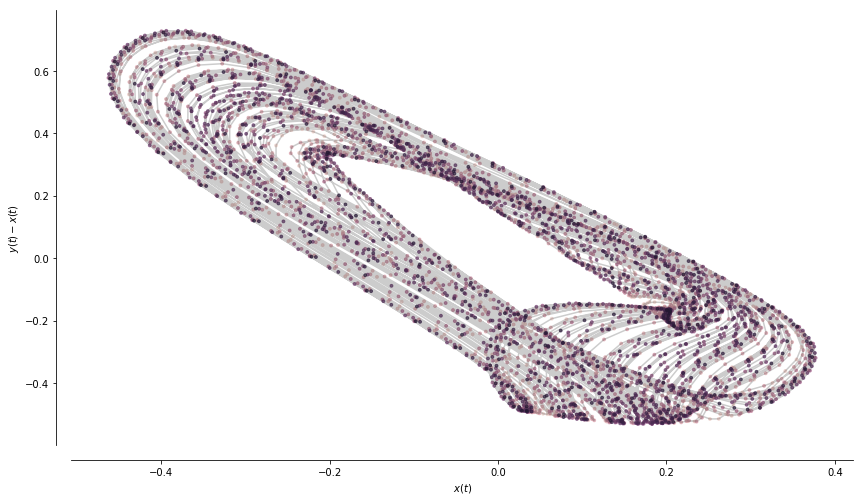

In [6]:
from phd import savefig

def cool_plot(X, Y, title="", fname=None):
    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.scatter(X[:, 0], Y[:, 0] - X[:, 0], s=8, alpha=0.7,
                c=np.arange(X.shape[0]), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.plot(X[:, 0], Y[:, 0] - X[:, 0], c='black', alpha=0.2)
    plt.xlabel("$x(t)$")
    plt.ylabel("$y(t) - x(t)$")
    sns.despine(offset=15)
    
    if fname is not None:
        savefig(fname)
    
    plt.show()

cool_plot(train_X[0], train_Y[0], fname="mackey-glass-example.pdf")

In [7]:
def make_lstm(num_units, num_layers):
    model = Sequential()
    model.add(LSTM(num_units,
                   input_shape=(train_X.shape[1], 1),  # (timesteps, input_dims)
                   return_sequences=True))  # continuously outputs per timestep
    for _ in range(num_layers-1):
        model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(train_X.shape[-1], activation='tanh'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model


def delay_layer(num_units, **kwargs):
    return RNN(DelayCell(num_units,
                         order=6,
                         theta_initializer=RandomUniform(25, 50),
                         encoder_initializer='lecun_uniform',
                         decoder_initializer='lecun_normal',
                         trainable_A=True,
                         trainable_B=True,
                        ),
               return_sequences=True,
               **kwargs)


def make_dn(num_units, num_layers):
    model = Sequential()
    model.add(delay_layer(num_units,
                          input_shape=(train_X.shape[1], 1)))  # (timesteps, input_dims)
    for _ in range(num_layers-1):
        model.add(delay_layer(num_units))
    model.add(Dense(train_X.shape[-1], activation='linear'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    
    return model


def make_hybrid(num_units, num_layers):
    assert num_layers == 4, "unsupported"
    model = Sequential()
    model.add(delay_layer(num_units, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(num_units, return_sequences=True))
    model.add(delay_layer(num_units))
    model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(train_X.shape[-1], activation='tanh'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model


num_units = 100
num_layers = 4

lstm_model = make_lstm(num_units, num_layers)
dn_model = make_dn(num_units, num_layers) 
hybrid_model = make_hybrid(num_units, num_layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5000, 100)         40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5000, 100)         80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 5000, 100)         80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 5000, 100)         80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5000, 1)           101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from tempfile import mktemp

import time
from phd import datapath                        

def fit(model, fname):
    #_tname = mktemp(suffix=".hdf5")
    callbacks = [#EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20),
                 ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)]
    
    start = time.time()
    epochs = 500
    result = model.fit(
        train_X, train_Y, batch_size=32,
        epochs=epochs, callbacks=callbacks, validation_split=0.5)
    model.load_weights(fname)  # load best weights
    return result, (time.time() - start) / epochs

In [9]:
lstm_history, lstm_time = fit(
    lstm_model, datapath("keras-lstm-mackey-glass.hdf5"))

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 57s 2s/step - loss: 0.0472 - val_loss: 0.0435

Epoch 00001: val_loss improved from inf to 0.04350, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 50s 2s/step - loss: 0.0436 - val_loss: 0.0390

Epoch 00002: val_loss improved from 0.04350 to 0.03905, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 3/500
32/32 [==============================] - 51s 2s/step - loss: 0.0391 - val_loss: 0.0325

Epoch 00003: val_loss improved from 0.03905 to 0.03254, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 49s 2s/step - loss: 0.0326 - val_loss: 0.0236

Epoch 00004: val_loss improved from 0.03254 to 0.02357, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 5/500


32/32 [==============================] - 50s 2s/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00046: val_loss improved from 0.00201 to 0.00193, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 47/500
32/32 [==============================] - 49s 2s/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00047: val_loss did not improve from 0.00193
Epoch 48/500
32/32 [==============================] - 48s 2s/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00048: val_loss did not improve from 0.00193
Epoch 49/500
32/32 [==============================] - 50s 2s/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00049: val_loss did not improve from 0.00193
Epoch 50/500
32/32 [==============================] - 49s 2s/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00050: val_loss improved from 0.00193 to 0.00189, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 51/500
32/32 [==============================] - 49s 2s/step - loss: 0.0019 

32/32 [==============================] - 50s 2s/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00082: val_loss improved from 0.00109 to 0.00107, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 83/500
32/32 [==============================] - 49s 2s/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00083: val_loss improved from 0.00107 to 0.00106, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 84/500
32/32 [==============================] - 49s 2s/step - loss: 0.0011 - val_loss: 0.0010

Epoch 00084: val_loss improved from 0.00106 to 0.00104, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 85/500
32/32 [==============================] - 49s 2s/step - loss: 0.0011 - val_loss: 0.0010

Epoch 00085: val_loss improved from 0.00104 to 0.00103, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 86/500
32/32 [==============================] - 48s 1s/

32/32 [==============================] - 49s 2s/step - loss: 7.4702e-04 - val_loss: 7.2792e-04

Epoch 00116: val_loss improved from 0.00074 to 0.00073, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 117/500
32/32 [==============================] - 49s 2s/step - loss: 7.3925e-04 - val_loss: 7.2052e-04

Epoch 00117: val_loss improved from 0.00073 to 0.00072, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 118/500
32/32 [==============================] - 50s 2s/step - loss: 7.3170e-04 - val_loss: 7.1321e-04

Epoch 00118: val_loss improved from 0.00072 to 0.00071, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 119/500
32/32 [==============================] - 51s 2s/step - loss: 7.2418e-04 - val_loss: 7.0594e-04

Epoch 00119: val_loss improved from 0.00071 to 0.00071, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 120/500
32/32 [=====


Epoch 00149: val_loss improved from 0.00052 to 0.00051, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 150/500
32/32 [==============================] - 49s 2s/step - loss: 5.1975e-04 - val_loss: 5.0904e-04

Epoch 00150: val_loss improved from 0.00051 to 0.00051, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 151/500
32/32 [==============================] - 49s 2s/step - loss: 5.1404e-04 - val_loss: 5.0356e-04

Epoch 00151: val_loss improved from 0.00051 to 0.00050, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 152/500
32/32 [==============================] - 48s 1s/step - loss: 5.0839e-04 - val_loss: 4.9814e-04

Epoch 00152: val_loss improved from 0.00050 to 0.00050, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 153/500
32/32 [==============================] - 49s 2s/step - loss: 5.0280e-04 - val_loss: 4.9278e-04

Epoch 00153

32/32 [==============================] - 49s 2s/step - loss: 3.6475e-04 - val_loss: 3.6180e-04

Epoch 00183: val_loss improved from 0.00036 to 0.00036, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 184/500
32/32 [==============================] - 50s 2s/step - loss: 3.6145e-04 - val_loss: 3.5878e-04

Epoch 00184: val_loss improved from 0.00036 to 0.00036, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 185/500
32/32 [==============================] - 51s 2s/step - loss: 3.5826e-04 - val_loss: 3.5587e-04

Epoch 00185: val_loss improved from 0.00036 to 0.00036, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 186/500
32/32 [==============================] - 50s 2s/step - loss: 3.5517e-04 - val_loss: 3.5305e-04

Epoch 00186: val_loss improved from 0.00036 to 0.00035, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 187/500
32/32 [=====


Epoch 00227: val_loss did not improve from 0.00031
Epoch 228/500
32/32 [==============================] - 50s 2s/step - loss: 3.2701e-04 - val_loss: 3.1545e-04

Epoch 00228: val_loss did not improve from 0.00031
Epoch 229/500
32/32 [==============================] - 50s 2s/step - loss: 3.1730e-04 - val_loss: 3.1500e-04

Epoch 00229: val_loss did not improve from 0.00031
Epoch 230/500
32/32 [==============================] - 50s 2s/step - loss: 3.1672e-04 - val_loss: 3.1564e-04

Epoch 00230: val_loss did not improve from 0.00031
Epoch 231/500
32/32 [==============================] - 49s 2s/step - loss: 3.1724e-04 - val_loss: 3.0729e-04

Epoch 00231: val_loss improved from 0.00031 to 0.00031, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 232/500
32/32 [==============================] - 50s 2s/step - loss: 3.0877e-04 - val_loss: 3.1353e-04

Epoch 00232: val_loss did not improve from 0.00031
Epoch 233/500
32/32 [==============================] - 48

Epoch 265/500
32/32 [==============================] - 49s 2s/step - loss: 2.6002e-04 - val_loss: 2.6321e-04

Epoch 00265: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 266/500
32/32 [==============================] - 47s 1s/step - loss: 2.5904e-04 - val_loss: 2.6163e-04

Epoch 00266: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 267/500
32/32 [==============================] - 48s 2s/step - loss: 2.5728e-04 - val_loss: 2.6079e-04

Epoch 00267: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 268/500
32/32 [==============================] - 50s 2s/step - loss: 2.5626e-04 - val_loss: 2.5931e-04

Epoch 00268: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 269/50


Epoch 00298: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 299/500
32/32 [==============================] - 48s 1s/step - loss: 2.1687e-04 - val_loss: 2.2595e-04

Epoch 00299: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 300/500
32/32 [==============================] - 50s 2s/step - loss: 2.1570e-04 - val_loss: 2.2496e-04

Epoch 00300: val_loss improved from 0.00023 to 0.00022, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 301/500
32/32 [==============================] - 50s 2s/step - loss: 2.1454e-04 - val_loss: 2.2399e-04

Epoch 00301: val_loss improved from 0.00022 to 0.00022, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 302/500
32/32 [==============================] - 49s 2s/step - loss: 2.1340e-04 - val_loss: 2.2301e-04

Epoch 00302

32/32 [==============================] - 50s 2s/step - loss: 2.7317e-04 - val_loss: 4.1530e-04

Epoch 00336: val_loss did not improve from 0.00021
Epoch 337/500
32/32 [==============================] - 49s 2s/step - loss: 4.0586e-04 - val_loss: 2.2238e-04

Epoch 00337: val_loss did not improve from 0.00021
Epoch 338/500
32/32 [==============================] - 49s 2s/step - loss: 2.1366e-04 - val_loss: 3.9342e-04

Epoch 00338: val_loss did not improve from 0.00021
Epoch 339/500
32/32 [==============================] - 49s 2s/step - loss: 3.8528e-04 - val_loss: 2.2337e-04

Epoch 00339: val_loss did not improve from 0.00021
Epoch 340/500
32/32 [==============================] - 48s 2s/step - loss: 2.1559e-04 - val_loss: 3.2062e-04

Epoch 00340: val_loss did not improve from 0.00021
Epoch 341/500
32/32 [==============================] - 48s 2s/step - loss: 3.1287e-04 - val_loss: 2.3769e-04

Epoch 00341: val_loss did not improve from 0.00021
Epoch 342/500
32/32 [===========================

Epoch 381/500
32/32 [==============================] - 50s 2s/step - loss: 1.7979e-04 - val_loss: 1.8851e-04

Epoch 00381: val_loss did not improve from 0.00019
Epoch 382/500
32/32 [==============================] - 49s 2s/step - loss: 1.8074e-04 - val_loss: 1.8626e-04

Epoch 00382: val_loss improved from 0.00019 to 0.00019, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 383/500
32/32 [==============================] - 49s 2s/step - loss: 1.7830e-04 - val_loss: 1.8724e-04

Epoch 00383: val_loss did not improve from 0.00019
Epoch 384/500
32/32 [==============================] - 50s 2s/step - loss: 1.7910e-04 - val_loss: 1.8537e-04

Epoch 00384: val_loss improved from 0.00019 to 0.00019, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 385/500
32/32 [==============================] - 50s 2s/step - loss: 1.7710e-04 - val_loss: 1.8578e-04

Epoch 00385: val_loss did not improve from 0.00019
Epoch 386/500
32/32 [==

Epoch 416/500
32/32 [==============================] - 50s 2s/step - loss: 1.6361e-04 - val_loss: 1.7561e-04

Epoch 00416: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 417/500
32/32 [==============================] - 49s 2s/step - loss: 1.6329e-04 - val_loss: 1.7541e-04

Epoch 00417: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 418/500
32/32 [==============================] - 49s 2s/step - loss: 1.6299e-04 - val_loss: 1.7527e-04

Epoch 00418: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 419/500
32/32 [==============================] - 49s 2s/step - loss: 1.6277e-04 - val_loss: 1.7507e-04

Epoch 00419: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 420/50


Epoch 00449: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 450/500
32/32 [==============================] - 50s 2s/step - loss: 1.5657e-04 - val_loss: 1.7093e-04

Epoch 00450: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 451/500
32/32 [==============================] - 49s 2s/step - loss: 1.5641e-04 - val_loss: 1.7081e-04

Epoch 00451: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 452/500
32/32 [==============================] - 49s 2s/step - loss: 1.5625e-04 - val_loss: 1.7069e-04

Epoch 00452: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 453/500
32/32 [==============================] - 49s 2s/step - loss: 1.5610e-04 - val_loss: 1.7058e-04

Epoch 00453

32/32 [==============================] - 49s 2s/step - loss: 1.5194e-04 - val_loss: 1.6706e-04

Epoch 00483: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 484/500
32/32 [==============================] - 51s 2s/step - loss: 1.5182e-04 - val_loss: 1.6695e-04

Epoch 00484: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 485/500
32/32 [==============================] - 50s 2s/step - loss: 1.5169e-04 - val_loss: 1.6683e-04

Epoch 00485: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 486/500
32/32 [==============================] - 49s 2s/step - loss: 1.5156e-04 - val_loss: 1.6671e-04

Epoch 00486: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-lstm-mackey-glass.hdf5
Epoch 487/500
32/32 [=====

In [10]:
dn_history, dn_time = fit(
    dn_model, datapath("keras-dn-mackey-glass.hdf5"))

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 32s 1s/step - loss: 0.0489 - val_loss: 0.0224

Epoch 00001: val_loss improved from inf to 0.02239, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 31s 957ms/step - loss: 0.0224 - val_loss: 0.0240

Epoch 00002: val_loss did not improve from 0.02239
Epoch 3/500
32/32 [==============================] - 30s 945ms/step - loss: 0.0239 - val_loss: 0.0152

Epoch 00003: val_loss improved from 0.02239 to 0.01520, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 30s 942ms/step - loss: 0.0152 - val_loss: 0.0186

Epoch 00004: val_loss did not improve from 0.01520
Epoch 5/500
32/32 [==============================] - 29s 916ms/step - loss: 0.0186 - val_loss: 0.0186

Epoch 00005: val_loss did not improve from 0.01520
Epoch 6/500
32/32 [======


Epoch 00041: val_loss did not improve from 0.00054
Epoch 42/500
32/32 [==============================] - 30s 934ms/step - loss: 5.8199e-04 - val_loss: 5.0955e-04

Epoch 00042: val_loss improved from 0.00054 to 0.00051, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 43/500
32/32 [==============================] - 30s 945ms/step - loss: 5.3594e-04 - val_loss: 5.9094e-04

Epoch 00043: val_loss did not improve from 0.00051
Epoch 44/500
32/32 [==============================] - 29s 921ms/step - loss: 6.1737e-04 - val_loss: 4.5280e-04

Epoch 00044: val_loss improved from 0.00051 to 0.00045, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 45/500
32/32 [==============================] - 30s 933ms/step - loss: 4.8000e-04 - val_loss: 4.7567e-04

Epoch 00045: val_loss did not improve from 0.00045
Epoch 46/500
32/32 [==============================] - 30s 925ms/step - loss: 5.0364e-04 - val_loss: 4.7579e-04

Epoch 00046: val


Epoch 00082: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 83/500
32/32 [==============================] - 30s 942ms/step - loss: 2.9342e-04 - val_loss: 2.6299e-04

Epoch 00083: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 84/500
32/32 [==============================] - 31s 959ms/step - loss: 2.9324e-04 - val_loss: 2.6231e-04

Epoch 00084: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 85/500
32/32 [==============================] - 29s 909ms/step - loss: 2.9260e-04 - val_loss: 2.6024e-04

Epoch 00085: val_loss improved from 0.00026 to 0.00026, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 86/500
32/32 [==============================] - 30s 950ms/step - loss: 2.9061e-04 - val_loss: 2.6090e-04

Epoch 00086

32/32 [==============================] - 31s 959ms/step - loss: 2.8134e-04 - val_loss: 2.5022e-04

Epoch 00118: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 119/500
32/32 [==============================] - 30s 947ms/step - loss: 2.8113e-04 - val_loss: 2.5012e-04

Epoch 00119: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 120/500
32/32 [==============================] - 30s 944ms/step - loss: 2.8103e-04 - val_loss: 2.4992e-04

Epoch 00120: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 121/500
32/32 [==============================] - 30s 941ms/step - loss: 2.8084e-04 - val_loss: 2.4979e-04

Epoch 00121: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 122/500
32/32 [=


Epoch 00151: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 152/500
32/32 [==============================] - 31s 957ms/step - loss: 2.7685e-04 - val_loss: 2.4572e-04

Epoch 00152: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 153/500
32/32 [==============================] - 31s 962ms/step - loss: 2.7673e-04 - val_loss: 2.4559e-04

Epoch 00153: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 154/500
32/32 [==============================] - 31s 967ms/step - loss: 2.7661e-04 - val_loss: 2.4547e-04

Epoch 00154: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 155/500
32/32 [==============================] - 29s 919ms/step - loss: 2.7649e-04 - val_loss: 2.4535e-04

Epoch 0

Epoch 185/500
32/32 [==============================] - 30s 923ms/step - loss: 2.7306e-04 - val_loss: 2.4192e-04

Epoch 00185: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 186/500
32/32 [==============================] - 29s 915ms/step - loss: 2.7295e-04 - val_loss: 2.4181e-04

Epoch 00186: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 187/500
32/32 [==============================] - 30s 941ms/step - loss: 2.7285e-04 - val_loss: 2.4170e-04

Epoch 00187: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 188/500
32/32 [==============================] - 31s 954ms/step - loss: 2.7274e-04 - val_loss: 2.4160e-04

Epoch 00188: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 18

32/32 [==============================] - 30s 949ms/step - loss: 2.6965e-04 - val_loss: 2.3851e-04

Epoch 00218: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 219/500
32/32 [==============================] - 30s 940ms/step - loss: 2.6955e-04 - val_loss: 2.3841e-04

Epoch 00219: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 220/500
32/32 [==============================] - 30s 953ms/step - loss: 2.6945e-04 - val_loss: 2.3831e-04

Epoch 00220: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 221/500
32/32 [==============================] - 30s 943ms/step - loss: 2.6935e-04 - val_loss: 2.3822e-04

Epoch 00221: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 222/500
32/32 [=


Epoch 00251: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 252/500
32/32 [==============================] - 30s 943ms/step - loss: 2.6656e-04 - val_loss: 2.3544e-04

Epoch 00252: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 253/500
32/32 [==============================] - 30s 947ms/step - loss: 2.6647e-04 - val_loss: 2.3536e-04

Epoch 00253: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 254/500
32/32 [==============================] - 30s 937ms/step - loss: 2.6639e-04 - val_loss: 2.3528e-04

Epoch 00254: val_loss improved from 0.00024 to 0.00024, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 255/500
32/32 [==============================] - 30s 935ms/step - loss: 2.6631e-04 - val_loss: 2.3520e-04

Epoch 0

Epoch 286/500
32/32 [==============================] - 30s 935ms/step - loss: 2.6400e-04 - val_loss: 2.3293e-04

Epoch 00286: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 287/500
32/32 [==============================] - 30s 944ms/step - loss: 2.6394e-04 - val_loss: 2.3287e-04

Epoch 00287: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 288/500
32/32 [==============================] - 30s 938ms/step - loss: 2.6387e-04 - val_loss: 2.3280e-04

Epoch 00288: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 289/500
32/32 [==============================] - 30s 945ms/step - loss: 2.6381e-04 - val_loss: 2.3274e-04

Epoch 00289: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 29

32/32 [==============================] - 30s 935ms/step - loss: 3.1807e-04 - val_loss: 6.3643e-04

Epoch 00324: val_loss did not improve from 0.00023
Epoch 325/500
32/32 [==============================] - 30s 929ms/step - loss: 6.6733e-04 - val_loss: 5.2833e-04

Epoch 00325: val_loss did not improve from 0.00023
Epoch 326/500
32/32 [==============================] - 29s 918ms/step - loss: 5.5913e-04 - val_loss: 2.4245e-04

Epoch 00326: val_loss did not improve from 0.00023
Epoch 327/500
32/32 [==============================] - 31s 955ms/step - loss: 2.7357e-04 - val_loss: 3.7630e-04

Epoch 00327: val_loss did not improve from 0.00023
Epoch 328/500
32/32 [==============================] - 30s 938ms/step - loss: 4.0735e-04 - val_loss: 4.6435e-04

Epoch 00328: val_loss did not improve from 0.00023
Epoch 329/500
32/32 [==============================] - 30s 925ms/step - loss: 4.9506e-04 - val_loss: 2.6596e-04

Epoch 00329: val_loss did not improve from 0.00023
Epoch 330/500
32/32 [=========


Epoch 00372: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 373/500
32/32 [==============================] - 31s 953ms/step - loss: 2.6080e-04 - val_loss: 2.3033e-04

Epoch 00373: val_loss did not improve from 0.00023
Epoch 374/500
32/32 [==============================] - 30s 947ms/step - loss: 2.6126e-04 - val_loss: 2.3108e-04

Epoch 00374: val_loss did not improve from 0.00023
Epoch 375/500
32/32 [==============================] - 31s 975ms/step - loss: 2.6198e-04 - val_loss: 2.2957e-04

Epoch 00375: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 376/500
32/32 [==============================] - 30s 939ms/step - loss: 2.6048e-04 - val_loss: 2.3020e-04

Epoch 00376: val_loss did not improve from 0.00023
Epoch 377/500
32/32 [==============================] - 30s 926ms/step - loss: 2.6112e-04 - val_loss: 2.3052e-04

Epoch 00377

32/32 [==============================] - 30s 951ms/step - loss: 2.5953e-04 - val_loss: 2.2863e-04

Epoch 00414: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 415/500
32/32 [==============================] - 31s 954ms/step - loss: 2.5950e-04 - val_loss: 2.2861e-04

Epoch 00415: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 416/500
32/32 [==============================] - 28s 889ms/step - loss: 2.5947e-04 - val_loss: 2.2861e-04

Epoch 00416: val_loss did not improve from 0.00023
Epoch 417/500
32/32 [==============================] - 31s 957ms/step - loss: 2.5947e-04 - val_loss: 2.2859e-04

Epoch 00417: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 418/500
32/32 [==============================] - 29s 920ms/step - loss: 2.5945e-04 - val_loss: 2.285


Epoch 00447: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 448/500
32/32 [==============================] - 30s 944ms/step - loss: 2.5898e-04 - val_loss: 2.2816e-04

Epoch 00448: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 449/500
32/32 [==============================] - 30s 945ms/step - loss: 2.5897e-04 - val_loss: 2.2815e-04

Epoch 00449: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 450/500
32/32 [==============================] - 28s 878ms/step - loss: 2.5896e-04 - val_loss: 2.2814e-04

Epoch 00450: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 451/500
32/32 [==============================] - 30s 946ms/step - loss: 2.5894e-04 - val_loss: 2.2812e-04

Epoch 0

Epoch 481/500
32/32 [==============================] - 29s 916ms/step - loss: 2.5861e-04 - val_loss: 2.2783e-04

Epoch 00481: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 482/500
32/32 [==============================] - 30s 932ms/step - loss: 2.5860e-04 - val_loss: 2.2782e-04

Epoch 00482: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 483/500
32/32 [==============================] - 30s 931ms/step - loss: 2.5859e-04 - val_loss: 2.2781e-04

Epoch 00483: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 484/500
32/32 [==============================] - 30s 932ms/step - loss: 2.5858e-04 - val_loss: 2.2780e-04

Epoch 00484: val_loss improved from 0.00023 to 0.00023, saving model to /home/arvoelke/CTN/phd/code/../data/keras-dn-mackey-glass.hdf5
Epoch 48

In [11]:
hybrid_history, hybrid_time = fit(
    hybrid_model, datapath("keras-hybrid-mackey-glass.hdf5"))

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 43s 1s/step - loss: 0.0383 - val_loss: 0.0143

Epoch 00001: val_loss improved from inf to 0.01428, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 41s 1s/step - loss: 0.0143 - val_loss: 0.0220

Epoch 00002: val_loss did not improve from 0.01428
Epoch 3/500
32/32 [==============================] - 40s 1s/step - loss: 0.0220 - val_loss: 0.0119

Epoch 00003: val_loss improved from 0.01428 to 0.01194, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 38s 1s/step - loss: 0.0120 - val_loss: 0.0081

Epoch 00004: val_loss improved from 0.01194 to 0.00815, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 5/500
32/32 [==============================] - 41s 1s/step - loss: 0.0082 - val_loss: 

Epoch 45/500
32/32 [==============================] - 40s 1s/step - loss: 3.8572e-04 - val_loss: 3.3988e-04

Epoch 00045: val_loss improved from 0.00036 to 0.00034, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 46/500
32/32 [==============================] - 40s 1s/step - loss: 3.6608e-04 - val_loss: 3.8009e-04

Epoch 00046: val_loss did not improve from 0.00034
Epoch 47/500
32/32 [==============================] - 41s 1s/step - loss: 4.0597e-04 - val_loss: 3.9860e-04

Epoch 00047: val_loss did not improve from 0.00034
Epoch 48/500
32/32 [==============================] - 40s 1s/step - loss: 4.2429e-04 - val_loss: 3.5757e-04

Epoch 00048: val_loss did not improve from 0.00034
Epoch 49/500
32/32 [==============================] - 41s 1s/step - loss: 3.8323e-04 - val_loss: 3.1482e-04

Epoch 00049: val_loss improved from 0.00034 to 0.00031, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 50/500
32/32 [====

32/32 [==============================] - 41s 1s/step - loss: 2.7573e-04 - val_loss: 2.5058e-04

Epoch 00086: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 87/500
32/32 [==============================] - 41s 1s/step - loss: 2.7442e-04 - val_loss: 2.4861e-04

Epoch 00087: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 88/500
32/32 [==============================] - 40s 1s/step - loss: 2.7235e-04 - val_loss: 2.4774e-04

Epoch 00088: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 89/500
32/32 [==============================] - 40s 1s/step - loss: 2.7139e-04 - val_loss: 2.4752e-04

Epoch 00089: val_loss improved from 0.00025 to 0.00025, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 90/500
32/32 [=

32/32 [==============================] - 40s 1s/step - loss: 2.4387e-04 - val_loss: 2.2224e-04

Epoch 00119: val_loss improved from 0.00022 to 0.00022, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 120/500
32/32 [==============================] - 40s 1s/step - loss: 2.4306e-04 - val_loss: 2.2149e-04

Epoch 00120: val_loss improved from 0.00022 to 0.00022, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 121/500
32/32 [==============================] - 40s 1s/step - loss: 2.4220e-04 - val_loss: 2.2073e-04

Epoch 00121: val_loss improved from 0.00022 to 0.00022, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 122/500
32/32 [==============================] - 39s 1s/step - loss: 2.4134e-04 - val_loss: 2.2003e-04

Epoch 00122: val_loss improved from 0.00022 to 0.00022, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 123/500
32/3

Epoch 152/500
32/32 [==============================] - 41s 1s/step - loss: 2.1746e-04 - val_loss: 1.9994e-04

Epoch 00152: val_loss improved from 0.00020 to 0.00020, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 153/500
32/32 [==============================] - 40s 1s/step - loss: 2.1670e-04 - val_loss: 1.9932e-04

Epoch 00153: val_loss improved from 0.00020 to 0.00020, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 154/500
32/32 [==============================] - 39s 1s/step - loss: 2.1595e-04 - val_loss: 1.9871e-04

Epoch 00154: val_loss improved from 0.00020 to 0.00020, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 155/500
32/32 [==============================] - 41s 1s/step - loss: 2.1520e-04 - val_loss: 1.9811e-04

Epoch 00155: val_loss improved from 0.00020 to 0.00020, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

Epoch 185/500
32/32 [==============================] - 40s 1s/step - loss: 1.9445e-04 - val_loss: 1.8199e-04

Epoch 00185: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 186/500
32/32 [==============================] - 40s 1s/step - loss: 1.9383e-04 - val_loss: 1.8153e-04

Epoch 00186: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 187/500
32/32 [==============================] - 40s 1s/step - loss: 1.9320e-04 - val_loss: 1.8107e-04

Epoch 00187: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 188/500
32/32 [==============================] - 40s 1s/step - loss: 1.9258e-04 - val_loss: 1.8061e-04

Epoch 00188: val_loss improved from 0.00018 to 0.00018, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

Epoch 218/500
32/32 [==============================] - 40s 1s/step - loss: 1.7628e-04 - val_loss: 1.6923e-04

Epoch 00218: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 219/500
32/32 [==============================] - 39s 1s/step - loss: 1.7581e-04 - val_loss: 1.6892e-04

Epoch 00219: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 220/500
32/32 [==============================] - 40s 1s/step - loss: 1.7535e-04 - val_loss: 1.6862e-04

Epoch 00220: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 221/500
32/32 [==============================] - 41s 1s/step - loss: 1.7489e-04 - val_loss: 1.6832e-04

Epoch 00221: val_loss improved from 0.00017 to 0.00017, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

Epoch 251/500
32/32 [==============================] - 40s 1s/step - loss: 1.6295e-04 - val_loss: 1.6086e-04

Epoch 00251: val_loss improved from 0.00016 to 0.00016, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 252/500
32/32 [==============================] - 40s 1s/step - loss: 1.6261e-04 - val_loss: 1.6065e-04

Epoch 00252: val_loss improved from 0.00016 to 0.00016, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 253/500
32/32 [==============================] - 41s 1s/step - loss: 1.6226e-04 - val_loss: 1.6044e-04

Epoch 00253: val_loss improved from 0.00016 to 0.00016, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 254/500
32/32 [==============================] - 39s 1s/step - loss: 1.6192e-04 - val_loss: 1.6024e-04

Epoch 00254: val_loss improved from 0.00016 to 0.00016, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

Epoch 284/500
32/32 [==============================] - 40s 1s/step - loss: 1.5259e-04 - val_loss: 1.5460e-04

Epoch 00284: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 285/500
32/32 [==============================] - 40s 1s/step - loss: 1.5229e-04 - val_loss: 1.5443e-04

Epoch 00285: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 286/500
32/32 [==============================] - 39s 1s/step - loss: 1.5201e-04 - val_loss: 1.5425e-04

Epoch 00286: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 287/500
32/32 [==============================] - 38s 1s/step - loss: 1.5172e-04 - val_loss: 1.5407e-04

Epoch 00287: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

32/32 [==============================] - 40s 1s/step - loss: 1.4326e-04 - val_loss: 1.4876e-04

Epoch 00317: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 318/500
32/32 [==============================] - 40s 1s/step - loss: 1.4298e-04 - val_loss: 1.4858e-04

Epoch 00318: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 319/500
32/32 [==============================] - 40s 1s/step - loss: 1.4270e-04 - val_loss: 1.4840e-04

Epoch 00319: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 320/500
32/32 [==============================] - 39s 1s/step - loss: 1.4242e-04 - val_loss: 1.4822e-04

Epoch 00320: val_loss improved from 0.00015 to 0.00015, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 321/500
32/3

Epoch 350/500
32/32 [==============================] - 41s 1s/step - loss: 1.3397e-04 - val_loss: 1.4274e-04

Epoch 00350: val_loss improved from 0.00014 to 0.00014, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 351/500
32/32 [==============================] - 41s 1s/step - loss: 1.3369e-04 - val_loss: 1.4256e-04

Epoch 00351: val_loss improved from 0.00014 to 0.00014, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 352/500
32/32 [==============================] - 40s 1s/step - loss: 1.3340e-04 - val_loss: 1.4238e-04

Epoch 00352: val_loss improved from 0.00014 to 0.00014, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 353/500
32/32 [==============================] - 40s 1s/step - loss: 1.3312e-04 - val_loss: 1.4219e-04

Epoch 00353: val_loss improved from 0.00014 to 0.00014, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

Epoch 383/500
32/32 [==============================] - 39s 1s/step - loss: 1.2489e-04 - val_loss: 1.3707e-04

Epoch 00383: val_loss improved from 0.00014 to 0.00014, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 384/500
32/32 [==============================] - 40s 1s/step - loss: 1.2468e-04 - val_loss: 1.3711e-04

Epoch 00384: val_loss did not improve from 0.00014
Epoch 385/500
32/32 [==============================] - 40s 1s/step - loss: 1.2462e-04 - val_loss: 1.3769e-04

Epoch 00385: val_loss did not improve from 0.00014
Epoch 386/500
32/32 [==============================] - 39s 1s/step - loss: 1.2510e-04 - val_loss: 1.4032e-04

Epoch 00386: val_loss did not improve from 0.00014
Epoch 387/500
32/32 [==============================] - 39s 1s/step - loss: 1.2764e-04 - val_loss: 1.5104e-04

Epoch 00387: val_loss did not improve from 0.00014
Epoch 388/500
32/32 [==============================] - 39s 1s/step - loss: 1.3824e-04 - val_loss: 1.9165e-0

Epoch 433/500
32/32 [==============================] - 41s 1s/step - loss: 1.2862e-04 - val_loss: 1.4135e-04

Epoch 00433: val_loss did not improve from 0.00014
Epoch 434/500
32/32 [==============================] - 41s 1s/step - loss: 1.3363e-04 - val_loss: 1.3662e-04

Epoch 00434: val_loss did not improve from 0.00014
Epoch 435/500
32/32 [==============================] - 40s 1s/step - loss: 1.2875e-04 - val_loss: 1.3916e-04

Epoch 00435: val_loss did not improve from 0.00014
Epoch 436/500
32/32 [==============================] - 40s 1s/step - loss: 1.3119e-04 - val_loss: 1.3708e-04

Epoch 00436: val_loss did not improve from 0.00014
Epoch 437/500
32/32 [==============================] - 39s 1s/step - loss: 1.2901e-04 - val_loss: 1.3731e-04

Epoch 00437: val_loss did not improve from 0.00014
Epoch 438/500
32/32 [==============================] - 40s 1s/step - loss: 1.2907e-04 - val_loss: 1.3739e-04

Epoch 00438: val_loss did not improve from 0.00014
Epoch 439/500
32/32 [=============

Epoch 473/500
32/32 [==============================] - 40s 1s/step - loss: 1.1878e-04 - val_loss: 1.3165e-04

Epoch 00473: val_loss improved from 0.00013 to 0.00013, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 474/500
32/32 [==============================] - 40s 1s/step - loss: 1.1861e-04 - val_loss: 1.3153e-04

Epoch 00474: val_loss improved from 0.00013 to 0.00013, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 475/500
32/32 [==============================] - 39s 1s/step - loss: 1.1837e-04 - val_loss: 1.3146e-04

Epoch 00475: val_loss improved from 0.00013 to 0.00013, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoch 476/500
32/32 [==============================] - 39s 1s/step - loss: 1.1819e-04 - val_loss: 1.3135e-04

Epoch 00476: val_loss improved from 0.00013 to 0.00013, saving model to /home/arvoelke/CTN/phd/code/../data/keras-hybrid-mackey-glass.hdf5
Epoc

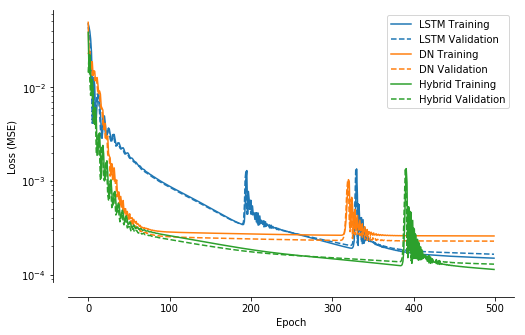

In [15]:
from phd import savefig

colors = sns.color_palette(None, 3)

plt.figure(figsize=(8, 5))
plt.plot(lstm_history.history['loss'], c=colors[0], label="LSTM Training")
plt.plot(lstm_history.history['val_loss'], c=colors[0], label="LSTM Validation", linestyle='--')

plt.plot(dn_history.history['loss'], c=colors[1], label="DN Training")
plt.plot(dn_history.history['val_loss'], c=colors[1], label="DN Validation", linestyle='--')

plt.plot(hybrid_history.history['loss'], c=colors[2], label="Hybrid Training")
plt.plot(hybrid_history.history['val_loss'], c=colors[2], label="Hybrid Validation", linestyle='--')

plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()

sns.despine(offset=15)

plt.show()

In [17]:
print(lstm_time, dn_time, hybrid_time)

49.94512908315659 30.531608286857605 40.45566932964325


In [21]:
lstm_Y = lstm_model.predict(test_X)
dn_Y = dn_model.predict(test_X)
hybrid_Y = hybrid_model.predict(test_X)

In [22]:
assert train_Y.shape[-1] == test_Y.shape[-1] == 1
print("LSTM", mean_squared_error(lstm_Y[:, :, 0], test_Y[:, :, 0]))
print("DN", mean_squared_error(dn_Y[:, :, 0], test_Y[:, :, 0]))
print("Hybrid", mean_squared_error(hybrid_Y[:, :, 0], test_Y[:, :, 0]))

LSTM 0.0002342732721176386
DN 0.0002148218299768388
Hybrid 0.0001735295789164618


In [32]:
from pandas import DataFrame
from collections import defaultdict
from nengolib.signal import nrmse

e_label = r'$\left(\hat{y}(t) - y(t)\right)^2$'

errors = defaultdict(list)
for name, pred_Y in (("LSTM", lstm_Y), ("DN", dn_Y), ("Hybrid", hybrid_Y)):
    print(name, "%.3f" % (100*nrmse(pred_Y.flatten(), target=test_Y.flatten())))
    
    for i in range(test_Y.shape[0]):
        for j in range(test_Y.shape[1]):
            errors[e_label].append((pred_Y[i, j, 0] - test_Y[i, j, 0])**2)
            errors['Time-step'].append(i)
            errors['Test'].append(j)
            errors['Method'].append(name)

LSTM 7.084
DN 6.783
Hybrid 6.097


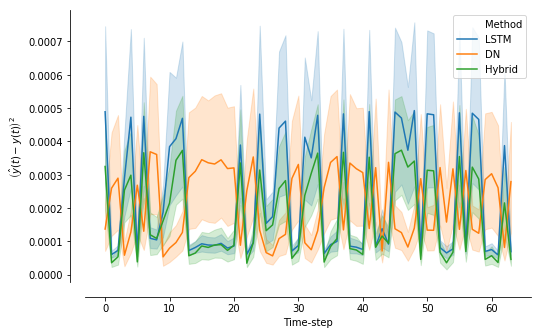

In [28]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=DataFrame(errors), x="Time-step", y=e_label, hue="Method")
#plt.xscale('log')
#plt.yscale('log')
sns.despine(offset=15)

plt.show()

In [30]:
lstm_model.save(datapath("keras-lstm-mackey-glass.hdf5"))
dn_model.save(datapath("keras-dn-mackey-glass.hdf5"))
hybrid_model.save(datapath("keras-hybrid-mackey-glass.hdf5"))